In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Aim :
1) Build a modular vision model with shared base features and multiple specialized processing units. Explain : what and how
2) Implement a dynamic routing mechanism that selects appropriate expert modules based on input data characteristics. Explain : What and how
3) Ensure that the model supports at least two tasks concurrently (e.g., disease grading classification and lesion segmentation).
Dataset : IDRiD (Indian Diabetic Retinopathy Image Dataset)

First since dataset is structure in a peculiar manner, I am creating a consolidated json file for segmentation task, ex:  [{image, "HE", "EX", "SE","OD""}].

In [ ]:
import os
import json
from pathlib import Path


In [ ]:


# === Config ===
base_dir = "/content/drive/MyDrive/idrid_dataset/A. Segmentation"
train_img_dir = Path(base_dir) / "1. Original Images" / "a. Training Set"

mask_base_dir = Path(base_dir) / "2. All Segmentation Groundtruths" / "a. Training Set"
lesion_dirs = {
    "MA": mask_base_dir / "1. Microaneurysms",
    "HE": mask_base_dir / "2. Haemorrhages",
    "EX": mask_base_dir / "3. Hard Exudates",
    "SE": mask_base_dir / "4. Soft Exudates",
    "OD": mask_base_dir / "5. Optic Disc"
}

#  Load all images
entries = []
for file in train_img_dir.glob("*.jpg"):
    image_id = file.stem  # Gets filename without extension
    entry = {
        "image": str(file.resolve())  # Absolute path with forward slashes
    }

    # Add each lesion mask path if available
    for lesion, dir_path in lesion_dirs.items():
        mask_filename = f"{image_id}_{lesion}.tif"
        mask_path = dir_path / mask_filename
        entry[lesion] = str(mask_path.resolve()) if mask_path.exists() else None

    entries.append(entry)


output_path = "segmentation_metadata_train.json"
with open(output_path, "w", encoding='utf-8') as f:  # utf-8 instead of utf-8-sig
    json.dump(entries, f, indent=4, ensure_ascii=False)  # ensure_ascii=False for proper path formatting

print(f" Saved {len(entries)} entries to {output_path}")
print(f"Sample entry: {json.dumps(entries[0], indent=2) if entries else 'No entries'}")

# Verify the JSON can be loaded back
try:
    with open(output_path, "r", encoding='utf-8') as f:
        test_load = json.load(f)
    print("JSON verification successful")
except Exception as e:
    print(f"JSON verification failed: {str(e)}")

 Saved 54 entries to segmentation_metadata_train.json
Sample entry: {
  "image": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/1. Original Images/a. Training Set/IDRiD_37.jpg",
  "MA": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms/IDRiD_37_MA.tif",
  "HE": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages/IDRiD_37_HE.tif",
  "EX": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates/IDRiD_37_EX.tif",
  "SE": null,
  "OD": "/content/drive/MyDrive/idrid_dataset/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/5. Optic Disc/IDRiD_37_OD.tif"
}
JSON verification successful


#Visualize Segmentation

In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



def load_json_data(json_path):
    try:
        with open(json_path, 'r') as f:
            # First check if file is empty
            content = f.read().strip()
            if not content:
                raise ValueError("JSON file is empty")

            # Try to parse JSON
            try:
                data = json.loads(content)
            except json.JSONDecodeError as e:
                # Try to fix common trailing comma issue
                if content.endswith(','):
                    content = content[:-1]
                    data = json.loads(content)
                else:
                    raise e
        return data
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return None

json_path = "/content/segmentation_metadata_train.json"
data = load_json_data(json_path)

# Load JSON data
  # Replace with your actual JSON path
with open(json_path) as f:
    data = json.load(f)

# Color mapping for different segmentation classes bgr
seg_colors = {
    "MA": (0, 0, 255),      # Red - Microaneurysms
    "HE": (0, 255, 0),      # Green - Haemorrhages
    "EX": (255, 0, 0),      # Blue - Hard Exudates
    "SE": (0, 255, 255),    # Yellow - Soft Exudates
    "OD": (255, 0, 255)     # Magenta - Optic Disc
}

# Class descriptions for legend
class_descriptions = {
    "MA": "Microaneurysms",
    "HE": "Haemorrhages",
    "EX": "Hard Exudates",
    "SE": "Soft Exudates",
    "OD": "Optic Disc"
}


Visualizing: IDRiD_37.jpg


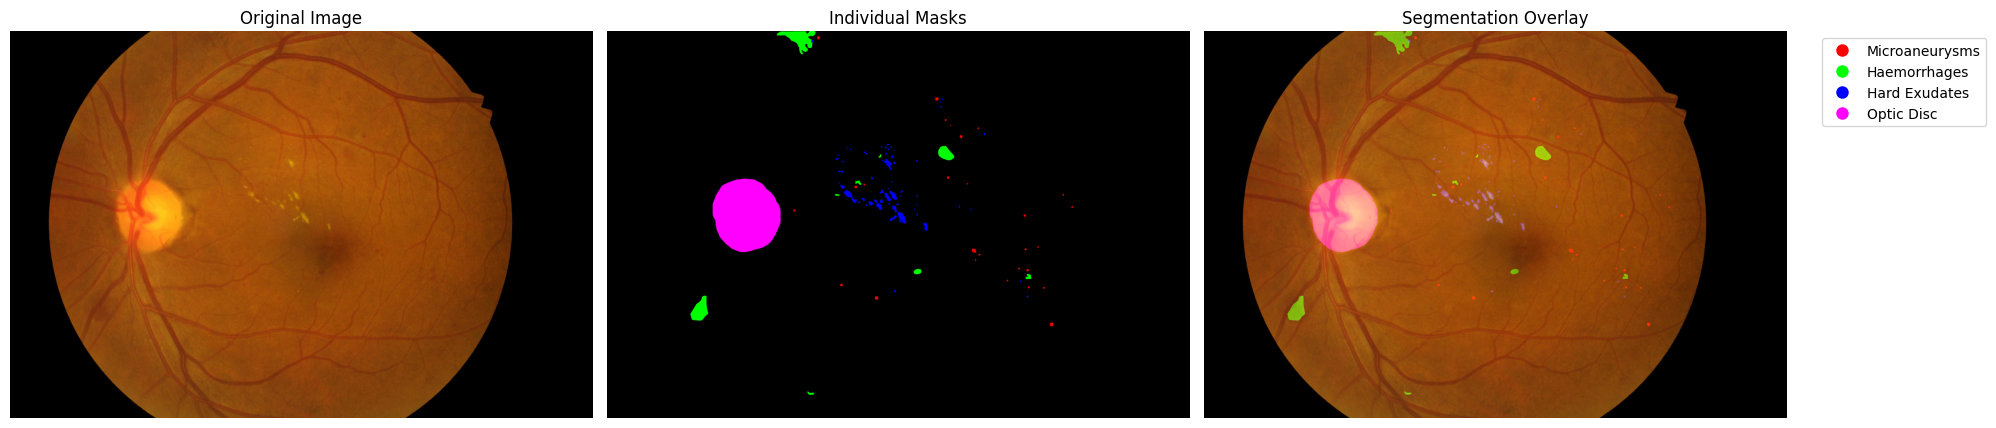


Visualizing: IDRiD_05.jpg


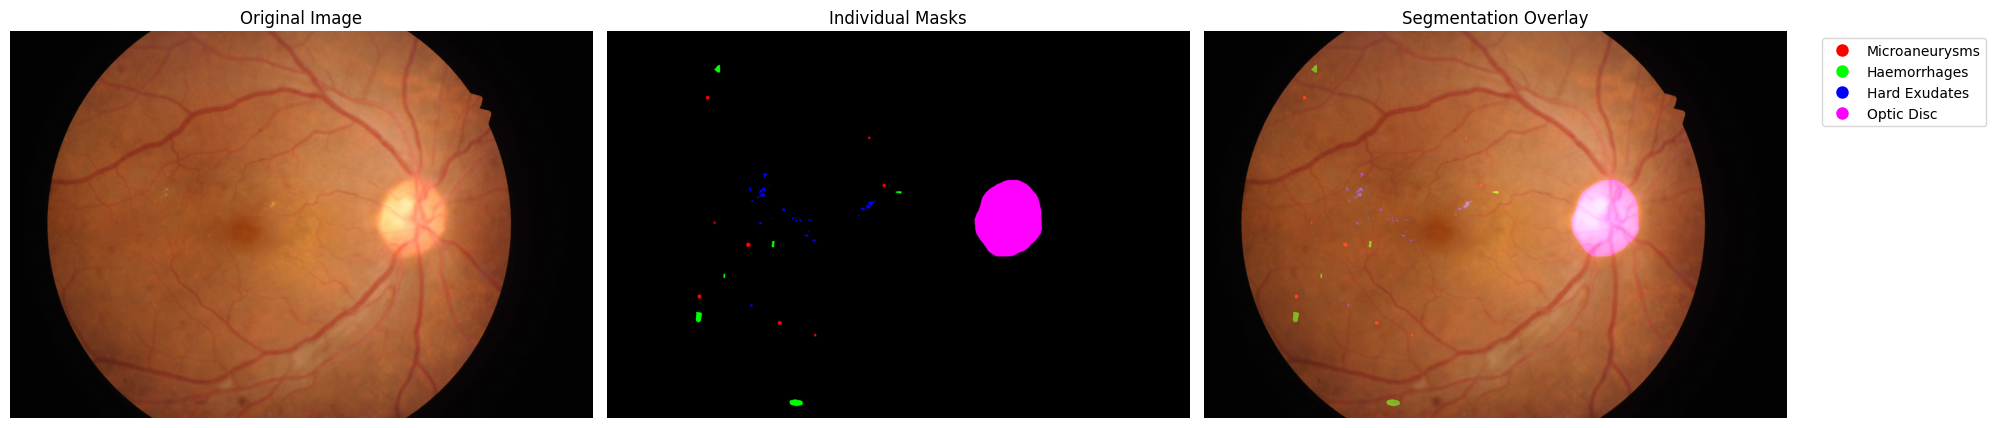


Visualizing: IDRiD_16.jpg


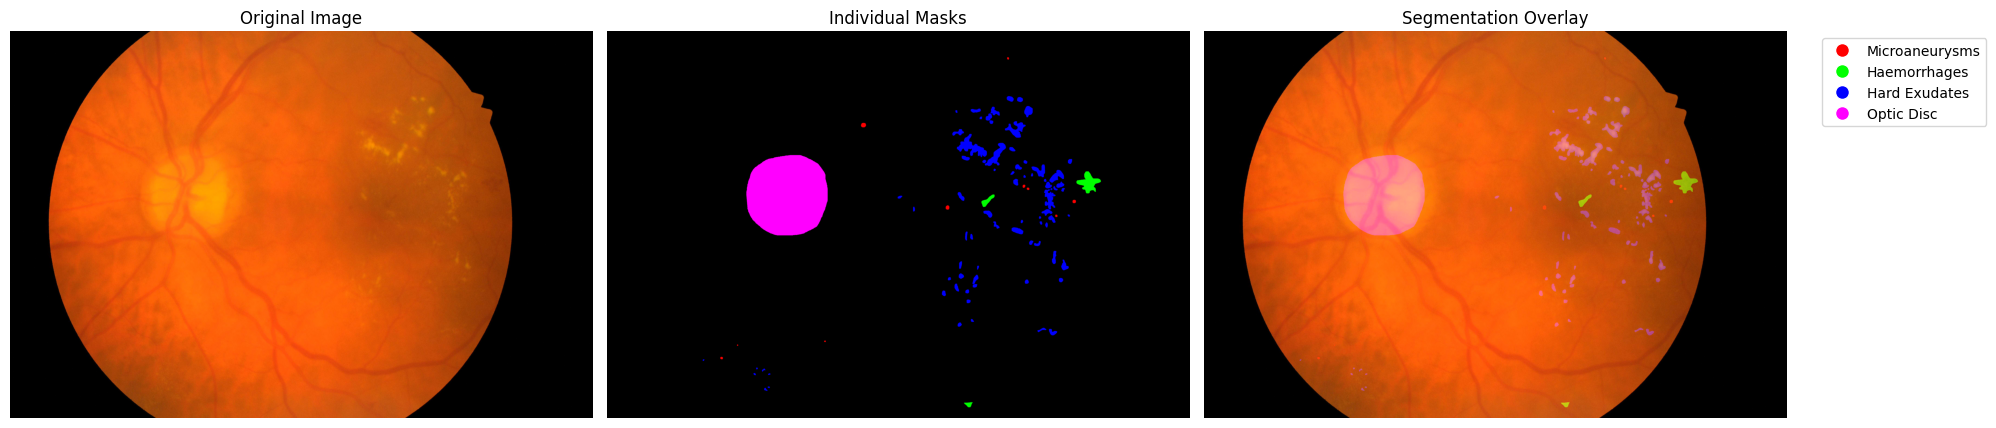


Visualizing: IDRiD_15.jpg


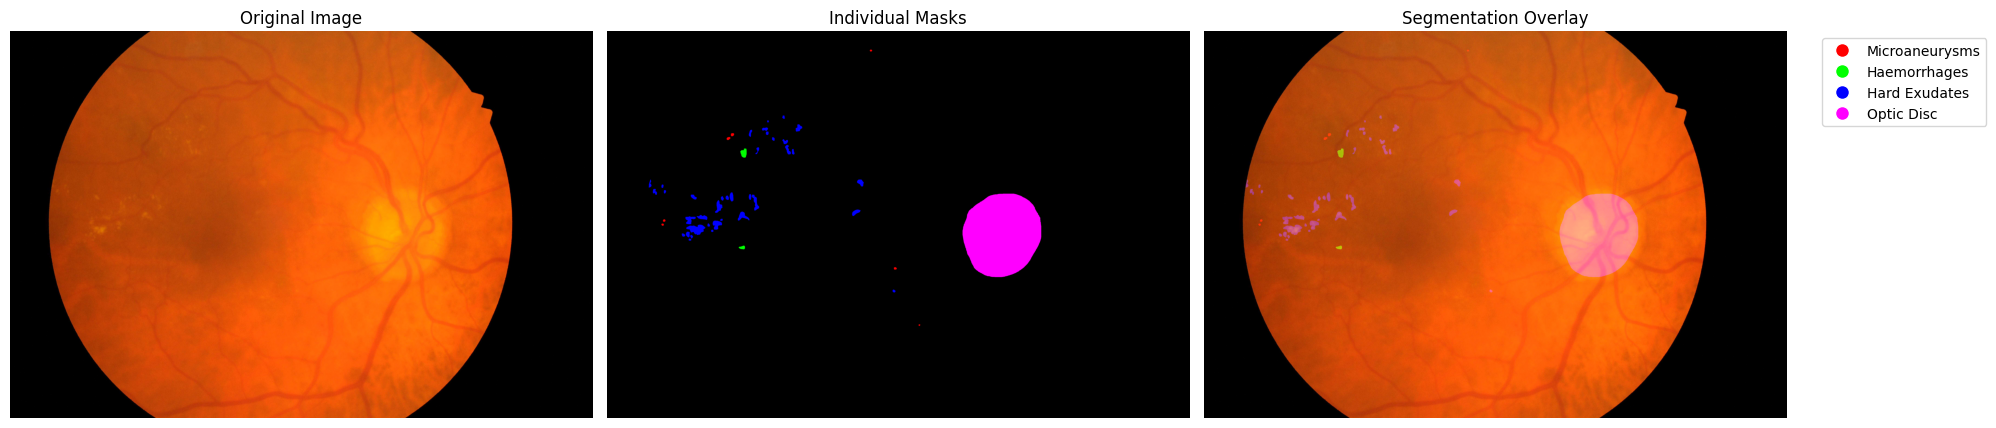


Visualizing: IDRiD_08.jpg


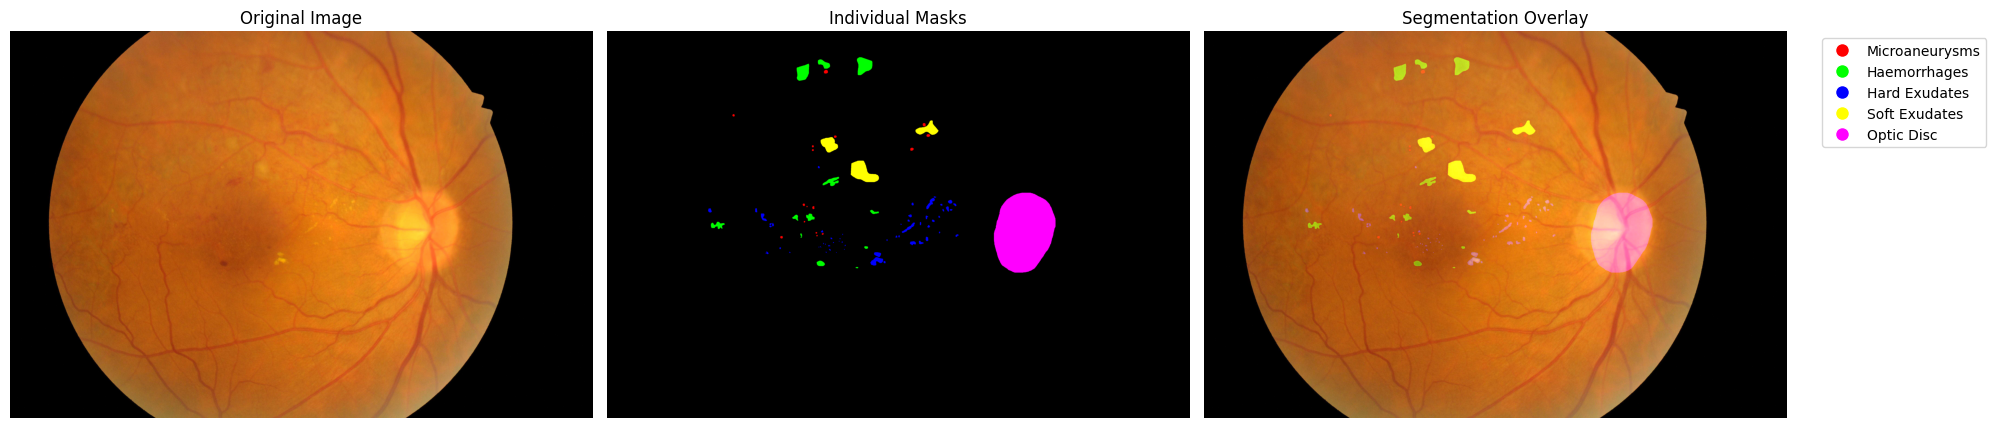

In [ ]:

def visualize_sample(sample):
    # Load original image
    image_path = sample["image"]
    if not Path(image_path).exists():
        print(f"Image not found: {image_path}")
        return

    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    overlay = image.copy()
    mask_display = np.zeros_like(image)

    # Create figure
    plt.figure(figsize=(20, 10))

    # Process each segmentation type
    for seg_type in ["MA", "HE", "EX", "SE", "OD"]:
        seg_path = sample[seg_type]

        # Skip if no mask for this type
        if seg_path is None:
            continue

        if not Path(seg_path).exists():
            print(f"Mask not found: {seg_path}")
            continue

        # Load mask (grayscale)
        mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Could not load mask: {seg_path}")
            continue

        # Threshold mask to ensure binary
        _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

        # Get color for this segmentation type (convert BGR to RGB)
        color = seg_colors[seg_type][::-1]

        # Add to mask display (for individual mask visualization)
        mask_display[binary_mask > 0] = color

        # Create colored mask for overlay
        color_mask = np.zeros_like(image)
        color_mask[binary_mask > 0] = color

        # Overlay with transparency
        overlay = cv2.addWeighted(color_mask, 0.5, overlay, 1, 0)

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Display individual masks
    plt.subplot(1, 3, 2)
    plt.imshow(mask_display)
    plt.title("Individual Masks")
    plt.axis('off')

    # Display overlay image
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Segmentation Overlay")
    plt.axis('off')

    # Create legend
    legend_elements = []
    for seg_type, color in seg_colors.items():
        # Skip if this type wasn't present in the sample
        if sample[seg_type] is None:
            continue

        rgb_color = np.array(color[::-1]) / 255.0  # Convert to RGB and normalize
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w', label=class_descriptions[seg_type],
                      markerfacecolor=rgb_color, markersize=10)
        )

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Visualize each sample in the JSON data
for sample in data[:5]:  # Visualize first 5 samples
    print(f"\nVisualizing: {Path(sample['image']).name}")
    visualize_sample(sample)

#segementation process :
Task definition - Given Image, network should be able to segment based on 5 classes : [Microaneurysms,Haemorrhages, Hard Exudates,Soft Exudates, Optic Disc]. And During prediction, use gradcam for visualization.
1) Create Dataloader - This will preproocess the data and handle null values.
2) Train Val - Creates train and validation sets.
3) Model  - Using Resnet50 trained on imagenet in a u-net structure for segementation.